In [1]:
# Import data from CSV files
from csv import DictReader

with open('_data/fluidized_bed.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows_fb = [r for r in reader]
csv_file.close()

with open('_data/batch_reactor.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows_br = [r for r in reader]
csv_file.close()

with open('_data/tubular_reactor.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    rows_tr = [r for r in reader]
csv_file.close()

INPUT_VARS = [
    'Reaction Time (s)',
    'Temperature (C)',
    'Particle size (mm)',
    'Moisture',
    'Ash',
    'C',
    'H',
    'N',
    'O'
]

TARGET_VARS = ['Oil', 'Char', 'Gas']

In [2]:
from typing import List, Tuple
import numpy as np

def pre_format(rows: List[dict], input_vars: List[str], target_vars: List[str]) -> Tuple[np.array]:

    X = []
    Y = []
    for row in rows:
        try:
            _x = []
            for inp in input_vars:
                _x.append(float(row[inp]))
            _y = []
            for tar in target_vars:
                _y.append(float(row[tar]) * 0.01)
            X.append(_x)
            Y.append(_y)
        except:
            continue

    return (np.array(X), np.array(Y))

X_fb, Y_fb = pre_format(rows_fb, INPUT_VARS, TARGET_VARS)
X_br, Y_br = pre_format(rows_br, INPUT_VARS, TARGET_VARS)
X_tr, Y_tr = pre_format(rows_tr, INPUT_VARS, TARGET_VARS)

print(X_fb.shape, Y_fb.shape)
print(X_br.shape, Y_br.shape)
print(X_tr.shape, Y_tr.shape)

(57, 9) (57, 3)
(22, 9) (22, 3)
(17, 9) (17, 3)


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_fb = scaler.fit_transform(X_fb)

scaler = MinMaxScaler()
X_br = scaler.fit_transform(X_br)

scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_tr)

In [4]:
from sklearn.model_selection import train_test_split

X_fb_train, X_fb_test, Y_fb_train, Y_fb_test = train_test_split(X_fb, Y_fb, test_size=0.25, random_state=42)
X_br_train, X_br_test, Y_br_train, Y_br_test = train_test_split(X_br, Y_br, test_size=0.25, random_state=42)
X_tr_train, X_tr_test, Y_tr_train, Y_tr_test = train_test_split(X_tr, Y_tr, test_size=0.25, random_state=42)

print(X_fb_train.shape, X_fb_test.shape, Y_fb_train.shape, Y_fb_test.shape)
print(X_br_train.shape, X_br_test.shape, Y_br_train.shape, Y_br_test.shape)
print(X_tr_train.shape, X_tr_test.shape, Y_tr_train.shape, Y_tr_test.shape)

(42, 9) (15, 9) (42, 3) (15, 3)
(16, 9) (6, 9) (16, 3) (6, 3)
(12, 9) (5, 9) (12, 3) (5, 3)


In [5]:
from structs import ReactorDataset

ds_fb_train = ReactorDataset(X_fb_train, Y_fb_train)
ds_fb_test = ReactorDataset(X_fb_test, Y_fb_test)

ds_br_train = ReactorDataset(X_br_train, Y_br_train)
ds_br_test = ReactorDataset(X_br_test, Y_br_test)

ds_tr_train = ReactorDataset(X_tr_train, Y_tr_train)
ds_tr_test = ReactorDataset(X_tr_test, Y_tr_test)

In [6]:
from structs import train_model, SoftmaxMLP
from sklearn.metrics import mean_absolute_error
from random import randint
import torch

models_fb = []
mae_test = []
epochs = []

for _ in range(50):

    _model = SoftmaxMLP(X_fb_train.shape[1], 64, 1, Y_fb_train.shape[1])
    _epoch = randint(200, 500)
    epochs.append(_epoch)
    _model, _ = train_model(_model, ds_fb_train, epochs=_epoch, batch_size=4, lr=0.01)
    models_fb.append(_model)
    mae_test.append(mean_absolute_error(Y_fb_test, _model(torch.tensor(X_fb_test).type(torch.float32)).detach().numpy()))

best_model_fb = models_fb[mae_test.index(min(mae_test))]
print(epochs[mae_test.index(min(mae_test))])

220


In [7]:
models_br = []
mae_test = []
epochs = []

for _ in range(50):

    _model = SoftmaxMLP(X_br_train.shape[1], 64, 1, Y_br_train.shape[1])
    _epoch = randint(200, 500)
    epochs.append(_epoch)
    _model, _ = train_model(_model, ds_br_train, epochs=_epoch, batch_size=4, lr=0.01)
    models_br.append(_model)
    mae_test.append(mean_absolute_error(Y_br_test, _model(torch.tensor(X_br_test).type(torch.float32)).detach().numpy()))

best_model_br = models_br[mae_test.index(min(mae_test))]
print(epochs[mae_test.index(min(mae_test))])

342


In [8]:
models_tr = []
mae_test = []
epochs = []

for _ in range(50):

    _model = SoftmaxMLP(X_tr_train.shape[1], 64, 1, Y_tr_train.shape[1])
    _epoch = randint(200, 500)
    epochs.append(_epoch)
    _model, _ = train_model(_model, ds_tr_train, epochs=_epoch, batch_size=4, lr=0.01)
    models_tr.append(_model)
    mae_test.append(mean_absolute_error(Y_tr_test, _model(torch.tensor(X_tr_test).type(torch.float32)).detach().numpy()))

best_model_tr = models_tr[mae_test.index(min(mae_test))]
print(epochs[mae_test.index(min(mae_test))])

212


In [9]:
import torch

pred_fb_train = best_model_fb(torch.tensor(X_fb_train).type(torch.float32)).detach().numpy()
pred_fb_test = best_model_fb(torch.tensor(X_fb_test).type(torch.float32)).detach().numpy()

pred_br_train = best_model_br(torch.tensor(X_br_train).type(torch.float32)).detach().numpy()
pred_br_test = best_model_br(torch.tensor(X_br_test).type(torch.float32)).detach().numpy()

pred_tr_train = best_model_tr(torch.tensor(X_tr_train).type(torch.float32)).detach().numpy()
pred_tr_test = best_model_tr(torch.tensor(X_tr_test).type(torch.float32)).detach().numpy()

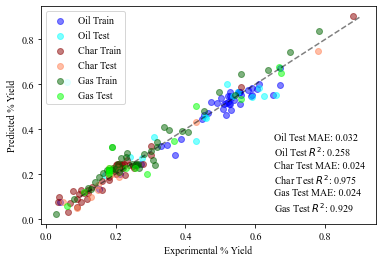

In [10]:
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import r2_score, median_absolute_error

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Experimental % Yield')
plt.ylabel('Predicted % Yield')

mae_oil_test = median_absolute_error([i[0] for i in Y_fb_test], [i[0] for i in pred_fb_test])
mae_char_test = median_absolute_error([i[1] for i in Y_fb_test], [i[1] for i in pred_fb_test])
mae_gas_test = median_absolute_error([i[2] for i in Y_fb_test], [i[2] for i in pred_fb_test])

r2_oil_test = r2_score([i[0] for i in Y_fb_test], [i[0] for i in pred_fb_test])
r2_char_test = r2_score([i[1] for i in Y_fb_test], [i[1] for i in pred_fb_test])
r2_gas_test = r2_score([i[2] for i in Y_fb_test], [i[2] for i in pred_fb_test])

plt.scatter([i[0] for i in Y_fb_train], [i[0] for i in pred_fb_train], color='blue', label='Oil Train', alpha=0.5)
plt.scatter([i[0] for i in Y_fb_test], [i[0] for i in pred_fb_test], color='cyan', label='Oil Test', alpha=0.5)
plt.scatter([i[1] for i in Y_fb_train], [i[1] for i in pred_fb_train], color='darkred', label='Char Train', alpha=0.5)
plt.scatter([i[1] for i in Y_fb_test], [i[1] for i in pred_fb_test], color='coral', label='Char Test', alpha=0.5)
plt.scatter([i[2] for i in Y_fb_train], [i[2] for i in pred_fb_train], color='darkgreen', label='Gas Train', alpha=0.5)
plt.scatter([i[2] for i in Y_fb_test], [i[2] for i in pred_fb_test], color='lime', label='Gas Test', alpha=0.5)
plt.plot([0.1, 0.9], [0.1, 0.9], linestyle='dashed', color='black', alpha=0.5)
plt.legend(loc='upper left')

string = 'Oil Test MAE: {:.3f}\nOil Test $R^2$: {:.3f}\nChar Test MAE: {:.3f}\nChar Test $R^2$: {:.3f}\nGas Test MAE: {:.3f}\nGas Test $R^2$: {:.3f}'.format(
    mae_oil_test, r2_oil_test, mae_char_test, r2_char_test, mae_gas_test, r2_gas_test
)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='w')
plt.gca().add_artist(text_box)

plt.show()


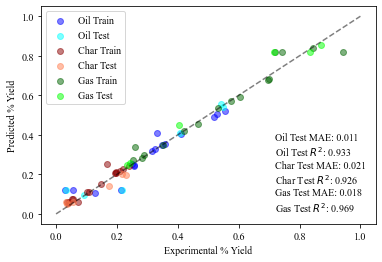

In [11]:
plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Experimental % Yield')
plt.ylabel('Predicted % Yield')

mae_oil_test = median_absolute_error([i[0] for i in Y_br_test], [i[0] for i in pred_br_test])
mae_char_test = median_absolute_error([i[1] for i in Y_br_test], [i[1] for i in pred_br_test])
mae_gas_test = median_absolute_error([i[2] for i in Y_br_test], [i[2] for i in pred_br_test])

r2_oil_test = r2_score([i[0] for i in Y_br_test], [i[0] for i in pred_br_test])
r2_char_test = r2_score([i[1] for i in Y_br_test], [i[1] for i in pred_br_test])
r2_gas_test = r2_score([i[2] for i in Y_br_test], [i[2] for i in pred_br_test])

plt.scatter([i[0] for i in Y_br_train], [i[0] for i in pred_br_train], color='blue', label='Oil Train', alpha=0.5)
plt.scatter([i[0] for i in Y_br_test], [i[0] for i in pred_br_test], color='cyan', label='Oil Test', alpha=0.5)
plt.scatter([i[1] for i in Y_br_train], [i[1] for i in pred_br_train], color='darkred', label='Char Train', alpha=0.5)
plt.scatter([i[1] for i in Y_br_test], [i[1] for i in pred_br_test], color='coral', label='Char Test', alpha=0.5)
plt.scatter([i[2] for i in Y_br_train], [i[2] for i in pred_br_train], color='darkgreen', label='Gas Train', alpha=0.5)
plt.scatter([i[2] for i in Y_br_test], [i[2] for i in pred_br_test], color='lime', label='Gas Test', alpha=0.5)
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='dashed', color='black', alpha=0.5)
plt.legend(loc='upper left')

string = 'Oil Test MAE: {:.3f}\nOil Test $R^2$: {:.3f}\nChar Test MAE: {:.3f}\nChar Test $R^2$: {:.3f}\nGas Test MAE: {:.3f}\nGas Test $R^2$: {:.3f}'.format(
    mae_oil_test, r2_oil_test, mae_char_test, r2_char_test, mae_gas_test, r2_gas_test
)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='w')
plt.gca().add_artist(text_box)

plt.show()

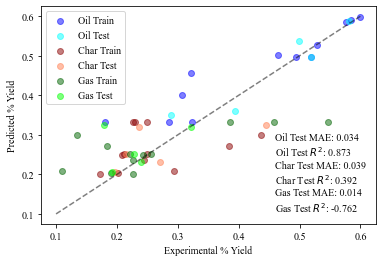

In [12]:
plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Experimental % Yield')
plt.ylabel('Predicted % Yield')

mae_oil_test = median_absolute_error([i[0] for i in Y_tr_test], [i[0] for i in pred_tr_test])
mae_char_test = median_absolute_error([i[1] for i in Y_tr_test], [i[1] for i in pred_tr_test])
mae_gas_test = median_absolute_error([i[2] for i in Y_tr_test], [i[2] for i in pred_tr_test])

r2_oil_test = r2_score([i[0] for i in Y_tr_test], [i[0] for i in pred_tr_test])
r2_char_test = r2_score([i[1] for i in Y_tr_test], [i[1] for i in pred_tr_test])
r2_gas_test = r2_score([i[2] for i in Y_tr_test], [i[2] for i in pred_tr_test])

plt.scatter([i[0] for i in Y_tr_train], [i[0] for i in pred_tr_train], color='blue', label='Oil Train', alpha=0.5)
plt.scatter([i[0] for i in Y_tr_test], [i[0] for i in pred_tr_test], color='cyan', label='Oil Test', alpha=0.5)
plt.scatter([i[1] for i in Y_tr_train], [i[1] for i in pred_tr_train], color='darkred', label='Char Train', alpha=0.5)
plt.scatter([i[1] for i in Y_tr_test], [i[1] for i in pred_tr_test], color='coral', label='Char Test', alpha=0.5)
plt.scatter([i[2] for i in Y_tr_train], [i[2] for i in pred_tr_train], color='darkgreen', label='Gas Train', alpha=0.5)
plt.scatter([i[2] for i in Y_tr_test], [i[2] for i in pred_tr_test], color='lime', label='Gas Test', alpha=0.5)
plt.plot([0.1, 0.6], [0.1, 0.6], linestyle='dashed', color='black', alpha=0.5)
plt.legend(loc='upper left')

string = 'Oil Test MAE: {:.3f}\nOil Test $R^2$: {:.3f}\nChar Test MAE: {:.3f}\nChar Test $R^2$: {:.3f}\nGas Test MAE: {:.3f}\nGas Test $R^2$: {:.3f}'.format(
    mae_oil_test, r2_oil_test, mae_char_test, r2_char_test, mae_gas_test, r2_gas_test
)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='w')
plt.gca().add_artist(text_box)

plt.show()

In [13]:
from copy import deepcopy

ds_all_train = deepcopy(ds_fb_train)
ds_all_train.X = torch.cat((ds_all_train.X, ds_br_train.X))
ds_all_train.X = torch.cat((ds_all_train.X, ds_tr_train.X))
ds_all_train.y = torch.cat((ds_all_train.y, ds_br_train.y))
ds_all_train.y = torch.cat((ds_all_train.y, ds_tr_train.y))

ds_all_test = deepcopy((ds_fb_test))
ds_all_test.X = torch.cat((ds_all_test.X, ds_br_test.X))
ds_all_test.X = torch.cat((ds_all_test.X, ds_tr_test.X))
ds_all_test.y = torch.cat((ds_all_test.y, ds_br_test.y))
ds_all_test.y = torch.cat((ds_all_test.y, ds_tr_test.y))

print(ds_all_train.X.shape, ds_all_train.y.shape)
print(ds_all_test.X.shape, ds_all_test.y.shape)

torch.Size([70, 9]) torch.Size([70, 3])
torch.Size([26, 9]) torch.Size([26, 3])


In [14]:
models_all = []
mae_test = []
epochs = []

for _ in range(50):

    _model = SoftmaxMLP(ds_all_train.X.shape[1], 64, 1, ds_all_train.y.shape[1])
    _epoch = randint(200, 500)
    epochs.append(_epoch)
    _model, _ = train_model(_model, ds_all_train, epochs=_epoch, batch_size=4, lr=0.01)
    models_all.append(_model)
    mae_test.append(mean_absolute_error(ds_all_test.y, _model(ds_all_test.X).detach().numpy()))

best_model_all = models_all[mae_test.index(min(mae_test))]
print(epochs[mae_test.index(min(mae_test))])

437


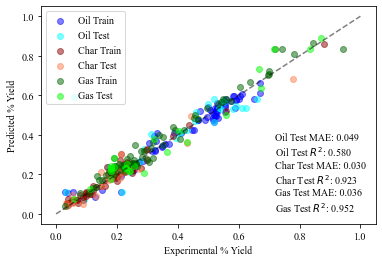

In [15]:
pred_all_train = best_model_all(ds_all_train.X).detach().numpy()
pred_all_test = best_model_all(ds_all_test.X).detach().numpy()

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Experimental % Yield')
plt.ylabel('Predicted % Yield')

mae_oil_test = median_absolute_error([i[0] for i in ds_all_test.y], [i[0] for i in pred_all_test])
mae_char_test = median_absolute_error([i[1] for i in ds_all_test.y], [i[1] for i in pred_all_test])
mae_gas_test = median_absolute_error([i[2] for i in ds_all_test.y], [i[2] for i in pred_all_test])

r2_oil_test = r2_score([i[0] for i in ds_all_test.y], [i[0] for i in pred_all_test])
r2_char_test = r2_score([i[1] for i in ds_all_test.y], [i[1] for i in pred_all_test])
r2_gas_test = r2_score([i[2] for i in ds_all_test.y], [i[2] for i in pred_all_test])

plt.scatter([i[0] for i in ds_all_train.y], [i[0] for i in pred_all_train], color='blue', label='Oil Train', alpha=0.5)
plt.scatter([i[0] for i in ds_all_test.y], [i[0] for i in pred_all_test], color='cyan', label='Oil Test', alpha=0.5)
plt.scatter([i[1] for i in ds_all_train.y], [i[1] for i in pred_all_train], color='darkred', label='Char Train', alpha=0.5)
plt.scatter([i[1] for i in ds_all_test.y], [i[1] for i in pred_all_test], color='coral', label='Char Test', alpha=0.5)
plt.scatter([i[2] for i in ds_all_train.y], [i[2] for i in pred_all_train], color='darkgreen', label='Gas Train', alpha=0.5)
plt.scatter([i[2] for i in ds_all_test.y], [i[2] for i in pred_all_test], color='lime', label='Gas Test', alpha=0.5)
plt.plot([0.0, 1.0], [0.0, 1.0], linestyle='dashed', color='black', alpha=0.5)
plt.legend(loc='upper left')

string = 'Oil Test MAE: {:.3f}\nOil Test $R^2$: {:.3f}\nChar Test MAE: {:.3f}\nChar Test $R^2$: {:.3f}\nGas Test MAE: {:.3f}\nGas Test $R^2$: {:.3f}'.format(
    mae_oil_test, r2_oil_test, mae_char_test, r2_char_test, mae_gas_test, r2_gas_test
)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='w')
plt.gca().add_artist(text_box)

plt.show()